## Rules

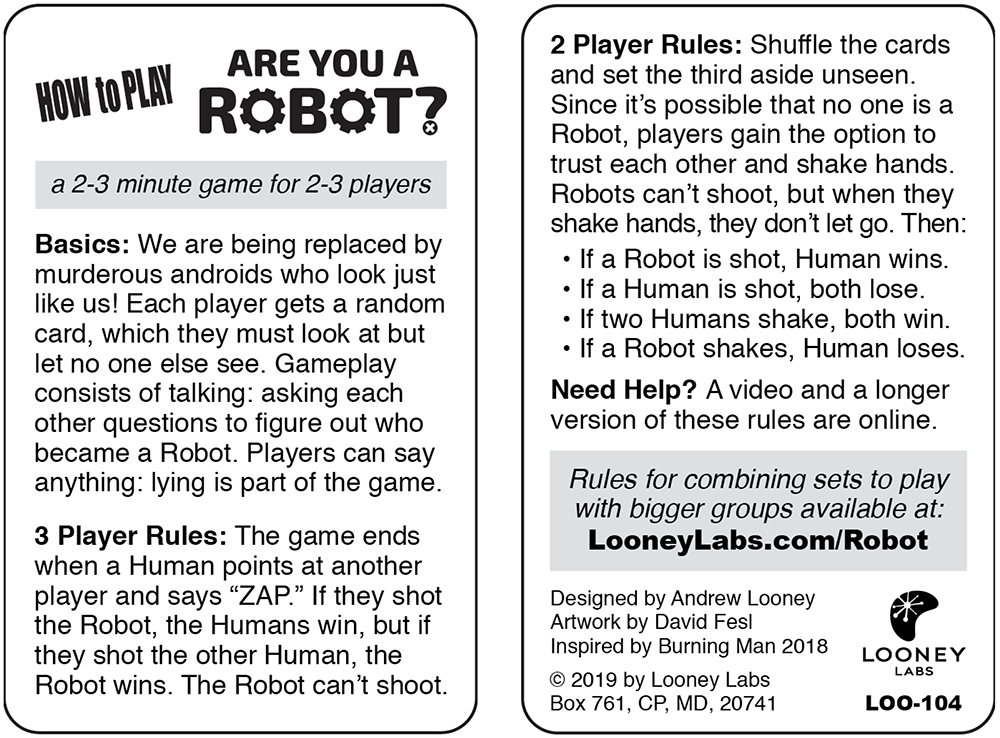

In [169]:
from enum import Enum
from random import choice, choices
import numpy as np


class Card(Enum):
    Human = 0
    Robot = 1 

class Choices(Enum):
    Unset = 0 
    Zap = 1
    Shake = 2


class Outcome(Enum):
    BothLose = 0
    BothWin = 1
    HumanWin = 2
    RobotWin = 3
    Stalemate = 4


def random_choice(player, hist):
    if not player.is_human: return Choices.Shake
    return choice([Choices.Zap, Choices.Shake])


def always_shake(player, hist):
    return Choices.Shake


def always_zap(player, hist):
    if not player.is_human: return Choices.Shake
    return Choices.Zap


class Player:
    def __init__(self, strategy=None):
        if strategy is None:
            strategy = random_choice
        self.strategy = strategy
        self.action = Choices.Unset

    def draw(self, deck: list):
        self.card = choice(deck)
        deck.pop(deck.index(self.card))

    def play(self, hist):
        self.action = self.strategy(self, hist)
        return self.action

    def set_action(self, action):
        if action  in [Choices.Zap, Choices.Shake]:

            self.action = action
        if action == 1:
            self.action = Choices.Zap
        else:
            self.action = Choices.Shake

    @property
    def is_human(self):
        return self.card == Card.Human
    
    @property
    def is_human_np(self):
        if self.is_human: return 1
        return 0
    
    @property
    def action_np(self):
        if self.action == Choices.Zap: return 1
        return 0

    
    def get_state(self):
        return self.is_human_np

def new_shuffled_deck():
    cards = [
        Card.Human,
        Card.Human,
        Card.Robot
    ]
    return choices(cards, k=3)

import gymnasium as gym
from gym import spaces

class AreYouARobotEnv(gym.Env):
    def __init__(self):

        # observations is a dictionary that contains whether or not 
        # the player chose shake or shoot or hasn't chosen yet, and whether or not the player 
        # is a robot or human 
        self.observation_space = spaces.Discrete(2)

        # 2 actions shoot or shake 
        self.action_space = spaces.Discrete(2)

    
    def _get_obs(self):
        return self.player_1.get_state()

    def reset(self):
        self.player_1 = Player()
        self.player_2 = Player()
        self.deck = new_shuffled_deck()
        self.player_1.draw(self.deck)
        self.player_2.draw(self.deck)
        return self._get_obs(), {}

    def step(self, action):
        if action == 0:
            action = Choices.Shake
        elif action == 1:
            action = Choices.Zap
        self.player_1.set_action(action)
        self.player_2.play([])

        if self.player_1.action == Choices.Zap:
            reward = 1 if self.player_2.is_human else -1
        elif self.player_1.action == Choices.Shake:
            if self.player_2.is_human and self.player_2.action == Choices.Zap:
                reward = -1
            elif self.player_2.is_human and self.player_2.action == Choices.Shake:
                reward = 1
            elif not self.player_2.is_human and self.player_2.action == Choices.Zap:
                reward = -1
            elif not self.player_2.is_human and self.player_2.action == Choices.Shake:
                reward = -1 
        else:
            raise Exception("Invalid action")

        return self._get_obs(), reward, True, {}, False

env = AreYouARobotEnv()

In [170]:
from collections import defaultdict

class QLearningAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
        env: gym.Env = AreYouARobotEnv(),
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []
        self.env = env

    def get_action(self, obs) -> int: 
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs,
        action: int,
        reward: float,
        terminated: bool,
        next_obs,
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [171]:
# reset the environment to get the first observation
done = False
observation, info = env.reset()
# sample a random action from all valid actions
action = env.action_space.sample()
# action=1

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)

# observation=(24, 10, False)
# reward=-1.0
# terminated=True
# truncated=False
# info={}
# observation = (16, 9, False)

In [172]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = QLearningAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    env=env,
)

In [173]:
from tqdm import tqdm

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:02<00:00, 35204.77it/s]


In [174]:
from pprint import pprint
pprint(agent.q_values)

defaultdict(<function QLearningAgent.__init__.<locals>.<lambda> at 0x7f2600d617e0>,
            {0: array([-0.27716185, -0.35802452]),
             1: array([-0.45342626, -0.42013713])})


In [175]:
def q_learning(player, hist):
    action = agent.get_action(player.is_human)
    if action == 0:
        return Choices.Shake
    elif action == 1:
        return Choices.Zap

In [176]:
from enum import Enum
from random import choice, choices


class Card(Enum):
    Human = 0
    Robot = 1 



class Choices(Enum):
    Zap = 0
    Shake = 1


class Outcome(Enum):
    BothLose = 0
    BothWin = 1
    HumanWin = 2
    RobotWin = 3
    Stalemate = 4


def random_choice(player, hist):
    if not player.is_human: return Choices.Shake
    return choice([Choices.Zap, Choices.Shake])


def always_shake(player, hist):
    return Choices.Shake


def always_zap(player, hist):
    if not player.is_human: return Choices.Shake
    return Choices.Zap


In [177]:
def biased_1_zap_to_99_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.1,0.99],
        k=1
    )[0]


def biased_2_zap_to_98_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.2,0.98],
        k=1
    )[0]


def biased_3_zap_to_97_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.3,0.97],
        k=1
    )[0]


def biased_4_zap_to_96_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.4,0.96],
        k=1
    )[0]


def biased_5_zap_to_95_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.5,0.95],
        k=1
    )[0]


def biased_6_zap_to_94_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.6,0.94],
        k=1
    )[0]


def biased_7_zap_to_93_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.7,0.93],
        k=1
    )[0]


def biased_8_zap_to_92_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.8,0.92],
        k=1
    )[0]


def biased_9_zap_to_91_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.9,0.91],
        k=1
    )[0]


def biased_10_zap_to_90_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.10,0.90],
        k=1
    )[0]


def biased_11_zap_to_89_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.11,0.89],
        k=1
    )[0]


def biased_12_zap_to_88_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.12,0.88],
        k=1
    )[0]


def biased_13_zap_to_87_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.13,0.87],
        k=1
    )[0]


def biased_14_zap_to_86_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.14,0.86],
        k=1
    )[0]


def biased_15_zap_to_85_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.15,0.85],
        k=1
    )[0]


def biased_16_zap_to_84_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.16,0.84],
        k=1
    )[0]


def biased_17_zap_to_83_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.17,0.83],
        k=1
    )[0]


def biased_18_zap_to_82_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.18,0.82],
        k=1
    )[0]


def biased_19_zap_to_81_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.19,0.81],
        k=1
    )[0]


def biased_20_zap_to_80_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.20,0.80],
        k=1
    )[0]


def biased_21_zap_to_79_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.21,0.79],
        k=1
    )[0]


def biased_22_zap_to_78_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.22,0.78],
        k=1
    )[0]


def biased_23_zap_to_77_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.23,0.77],
        k=1
    )[0]


def biased_24_zap_to_76_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.24,0.76],
        k=1
    )[0]


def biased_25_zap_to_75_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.25,0.75],
        k=1
    )[0]


def biased_26_zap_to_74_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.26,0.74],
        k=1
    )[0]


def biased_27_zap_to_73_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.27,0.73],
        k=1
    )[0]


def biased_28_zap_to_72_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.28,0.72],
        k=1
    )[0]


def biased_29_zap_to_71_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.29,0.71],
        k=1
    )[0]


def biased_30_zap_to_70_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.30,0.70],
        k=1
    )[0]


def biased_31_zap_to_69_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.31,0.69],
        k=1
    )[0]


def biased_32_zap_to_68_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.32,0.68],
        k=1
    )[0]


def biased_33_zap_to_67_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.33,0.67],
        k=1
    )[0]


def biased_34_zap_to_66_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.34,0.66],
        k=1
    )[0]


def biased_35_zap_to_65_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.35,0.65],
        k=1
    )[0]


def biased_36_zap_to_64_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.36,0.64],
        k=1
    )[0]


def biased_37_zap_to_63_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.37,0.63],
        k=1
    )[0]


def biased_38_zap_to_62_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.38,0.62],
        k=1
    )[0]


def biased_39_zap_to_61_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.39,0.61],
        k=1
    )[0]


def biased_40_zap_to_60_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.40,0.60],
        k=1
    )[0]


def biased_41_zap_to_59_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.41,0.59],
        k=1
    )[0]


def biased_42_zap_to_58_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.42,0.58],
        k=1
    )[0]


def biased_43_zap_to_57_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.43,0.57],
        k=1
    )[0]


def biased_44_zap_to_56_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.44,0.56],
        k=1
    )[0]


def biased_45_zap_to_55_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.45,0.55],
        k=1
    )[0]


def biased_46_zap_to_54_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.46,0.54],
        k=1
    )[0]


def biased_47_zap_to_53_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.47,0.53],
        k=1
    )[0]


def biased_48_zap_to_52_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.48,0.52],
        k=1
    )[0]


def biased_49_zap_to_51_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.49,0.51],
        k=1
    )[0]


def biased_50_zap_to_50_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.50,0.50],
        k=1
    )[0]


def biased_51_zap_to_49_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.51,0.49],
        k=1
    )[0]


def biased_52_zap_to_48_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.52,0.48],
        k=1
    )[0]


def biased_53_zap_to_47_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.53,0.47],
        k=1
    )[0]


def biased_54_zap_to_46_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.54,0.46],
        k=1
    )[0]


def biased_55_zap_to_45_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.55,0.45],
        k=1
    )[0]


def biased_56_zap_to_44_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.56,0.44],
        k=1
    )[0]


def biased_57_zap_to_43_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.57,0.43],
        k=1
    )[0]


def biased_58_zap_to_42_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.58,0.42],
        k=1
    )[0]


def biased_59_zap_to_41_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.59,0.41],
        k=1
    )[0]


def biased_60_zap_to_40_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.60,0.40],
        k=1
    )[0]


def biased_61_zap_to_39_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.61,0.39],
        k=1
    )[0]


def biased_62_zap_to_38_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.62,0.38],
        k=1
    )[0]


def biased_63_zap_to_37_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.63,0.37],
        k=1
    )[0]


def biased_64_zap_to_36_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.64,0.36],
        k=1
    )[0]


def biased_65_zap_to_35_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.65,0.35],
        k=1
    )[0]


def biased_66_zap_to_34_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.66,0.34],
        k=1
    )[0]


def biased_67_zap_to_33_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.67,0.33],
        k=1
    )[0]


def biased_68_zap_to_32_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.68,0.32],
        k=1
    )[0]


def biased_69_zap_to_31_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.69,0.31],
        k=1
    )[0]


def biased_70_zap_to_30_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.70,0.30],
        k=1
    )[0]


def biased_71_zap_to_29_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.71,0.29],
        k=1
    )[0]


def biased_72_zap_to_28_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.72,0.28],
        k=1
    )[0]


def biased_73_zap_to_27_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.73,0.27],
        k=1
    )[0]


def biased_74_zap_to_26_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.74,0.26],
        k=1
    )[0]


def biased_75_zap_to_25_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.75,0.25],
        k=1
    )[0]


def biased_76_zap_to_24_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.76,0.24],
        k=1
    )[0]


def biased_77_zap_to_23_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.77,0.23],
        k=1
    )[0]


def biased_78_zap_to_22_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.78,0.22],
        k=1
    )[0]


def biased_79_zap_to_21_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.79,0.21],
        k=1
    )[0]


def biased_80_zap_to_20_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.80,0.20],
        k=1
    )[0]


def biased_81_zap_to_19_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.81,0.19],
        k=1
    )[0]


def biased_82_zap_to_18_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.82,0.18],
        k=1
    )[0]


def biased_83_zap_to_17_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.83,0.17],
        k=1
    )[0]


def biased_84_zap_to_16_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.84,0.16],
        k=1
    )[0]


def biased_85_zap_to_15_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.85,0.15],
        k=1
    )[0]


def biased_86_zap_to_14_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.86,0.14],
        k=1
    )[0]


def biased_87_zap_to_13_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.87,0.13],
        k=1
    )[0]


def biased_88_zap_to_12_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.88,0.12],
        k=1
    )[0]


def biased_89_zap_to_11_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.89,0.11],
        k=1
    )[0]


def biased_90_zap_to_10_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.90,0.10],
        k=1
    )[0]


def biased_91_zap_to_9_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.91,0.9],
        k=1
    )[0]


def biased_92_zap_to_8_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.92,0.8],
        k=1
    )[0]


def biased_93_zap_to_7_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.93,0.7],
        k=1
    )[0]


def biased_94_zap_to_6_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.94,0.6],
        k=1
    )[0]


def biased_95_zap_to_5_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.95,0.5],
        k=1
    )[0]


def biased_96_zap_to_4_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.96,0.4],
        k=1
    )[0]


def biased_97_zap_to_3_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.97,0.3],
        k=1
    )[0]


def biased_98_zap_to_2_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.98,0.2],
        k=1
    )[0]


def biased_99_zap_to_1_shake(player, hist):
    if not player.is_human: return Choices.Shake
    return choices(
        population=[Choices.Zap, Choices.Shake],
        weights=[0.99,0.1],
        k=1
    )[0]


In [178]:
all_strategies = [
    always_shake, 
    random_choice, 
    always_zap, 
biased_1_zap_to_99_shake,
biased_2_zap_to_98_shake,
biased_3_zap_to_97_shake,
biased_4_zap_to_96_shake,
biased_5_zap_to_95_shake,
biased_6_zap_to_94_shake,
biased_7_zap_to_93_shake,
biased_8_zap_to_92_shake,
biased_9_zap_to_91_shake,
biased_10_zap_to_90_shake,
biased_11_zap_to_89_shake,
biased_12_zap_to_88_shake,
biased_13_zap_to_87_shake,
biased_14_zap_to_86_shake,
biased_15_zap_to_85_shake,
biased_16_zap_to_84_shake,
biased_17_zap_to_83_shake,
biased_18_zap_to_82_shake,
biased_19_zap_to_81_shake,
biased_20_zap_to_80_shake,
biased_21_zap_to_79_shake,
biased_22_zap_to_78_shake,
biased_23_zap_to_77_shake,
biased_24_zap_to_76_shake,
biased_25_zap_to_75_shake,
biased_26_zap_to_74_shake,
biased_27_zap_to_73_shake,
biased_28_zap_to_72_shake,
biased_29_zap_to_71_shake,
biased_30_zap_to_70_shake,
biased_31_zap_to_69_shake,
biased_32_zap_to_68_shake,
biased_33_zap_to_67_shake,
biased_34_zap_to_66_shake,
biased_35_zap_to_65_shake,
biased_36_zap_to_64_shake,
biased_37_zap_to_63_shake,
biased_38_zap_to_62_shake,
biased_39_zap_to_61_shake,
biased_40_zap_to_60_shake,
biased_41_zap_to_59_shake,
biased_42_zap_to_58_shake,
biased_43_zap_to_57_shake,
biased_44_zap_to_56_shake,
biased_45_zap_to_55_shake,
biased_46_zap_to_54_shake,
biased_47_zap_to_53_shake,
biased_48_zap_to_52_shake,
biased_49_zap_to_51_shake,
biased_50_zap_to_50_shake,
biased_51_zap_to_49_shake,
biased_52_zap_to_48_shake,
biased_53_zap_to_47_shake,
biased_54_zap_to_46_shake,
biased_55_zap_to_45_shake,
biased_56_zap_to_44_shake,
biased_57_zap_to_43_shake,
biased_58_zap_to_42_shake,
biased_59_zap_to_41_shake,
biased_60_zap_to_40_shake,
biased_61_zap_to_39_shake,
biased_62_zap_to_38_shake,
biased_63_zap_to_37_shake,
biased_64_zap_to_36_shake,
biased_65_zap_to_35_shake,
biased_66_zap_to_34_shake,
biased_67_zap_to_33_shake,
biased_68_zap_to_32_shake,
biased_69_zap_to_31_shake,
biased_70_zap_to_30_shake,
biased_71_zap_to_29_shake,
biased_72_zap_to_28_shake,
biased_73_zap_to_27_shake,
biased_74_zap_to_26_shake,
biased_75_zap_to_25_shake,
biased_76_zap_to_24_shake,
biased_77_zap_to_23_shake,
biased_78_zap_to_22_shake,
biased_79_zap_to_21_shake,
biased_80_zap_to_20_shake,
biased_81_zap_to_19_shake,
biased_82_zap_to_18_shake,
biased_83_zap_to_17_shake,
biased_84_zap_to_16_shake,
biased_85_zap_to_15_shake,
biased_86_zap_to_14_shake,
biased_87_zap_to_13_shake,
biased_88_zap_to_12_shake,
biased_89_zap_to_11_shake,
biased_90_zap_to_10_shake,
biased_91_zap_to_9_shake,
biased_92_zap_to_8_shake,
biased_93_zap_to_7_shake,
biased_94_zap_to_6_shake,
biased_95_zap_to_5_shake,
biased_96_zap_to_4_shake,
biased_97_zap_to_3_shake,
biased_98_zap_to_2_shake,
biased_99_zap_to_1_shake,
]

In [179]:
reduced_sample_strategies = [
    always_shake, 
    random_choice, 
    always_zap, 
    biased_10_zap_to_90_shake,
biased_20_zap_to_80_shake,
biased_30_zap_to_70_shake,
biased_40_zap_to_60_shake,
biased_50_zap_to_50_shake,
biased_60_zap_to_40_shake,
biased_70_zap_to_30_shake,
biased_80_zap_to_20_shake,
biased_90_zap_to_10_shake,
q_learning,

]


In [180]:
basic_strats = [
  always_shake, 
  random_choice, 
  always_zap, 
  q_learning,
]

In [181]:
zap_biased_strats_smaller_sample = [
biased_10_zap_to_90_shake,
biased_20_zap_to_80_shake,
biased_30_zap_to_70_shake,
biased_40_zap_to_60_shake,
biased_50_zap_to_50_shake,
biased_60_zap_to_40_shake,
biased_70_zap_to_30_shake,
biased_80_zap_to_20_shake,
biased_90_zap_to_10_shake,
q_learning,
]

In [182]:

class Player:
    def __init__(self, strategy=None):
        if strategy is None:
            strategy = random_choice
        self.strategy = strategy

    def draw(self, deck: list):
        self.card = choice(deck)
        deck.pop(deck.index(self.card))

    def play(self, hist):
        return self.strategy(self, hist)

    @property
    def is_human(self):
        return self.card == Card.Human


class Game:
    def __init__(self, players, deck, turn_limit=100):
        self.players = players
        self.deck = deck[:]
        self.turn_limit = turn_limit
        self.hist = []
        self.outcome = None

        for player in players:
            player.draw(deck)

    def add_turn(self):
        turn = []
        for player in self.players:
            turn.append(player.play(self.hist))
        self.hist.append(turn)

    def play(self):
        while len(self.hist) < self.turn_limit:
            self.add_turn()
            current_turn = self.hist[-1]
            if all([c == Choices.Shake for c in current_turn]):
                if all([p.is_human for p in self.players]):
                    return Outcome.BothWin
                else:
                    return Outcome.RobotWin
            # TODO: this only works for checking two player
            for (
                idx,
                c,
            ) in enumerate(current_turn):
                if c == Choices.Zap:
                    player_zapped = self.players[
                        not bool(idx)
                    ]  # only works for two player and kind of hacky
                    if player_zapped.is_human:
                        return Outcome.BothLose
                    else:
                        return Outcome.HumanWin
        return Outcome.Stalemate

    def apply_rules(self, turn):
        player_zero_play = turn[0]
        player_one_play = turn[1]

        if player_one_play == Choices.Shake and player_zero_play == Choices.Shake:
            if all([player.is_human for player in self.players]):
                return Outcome.BothWin
            else:
                return Outcome.RobotWin

    def get_outcome(self):
        if self.outcome == None:
            self.outcome = self.play()
        return self.outcome

    def player_index_is_winner(self, idx):
        player = self.players[idx]
        outcome = self.get_outcome()
        if outcome == Outcome.BothWin:
            return True
        elif outcome == Outcome.BothLose or outcome == Outcome.Stalemate:
            return False
        elif outcome == Outcome.HumanWin:
            return player.is_human
        elif outcome == Outcome.RobotWin:
            return not player.is_human


class Trial:
    def __init__(self, players, deck, turn_limit=100, n=100) -> None:
        self.d = {
            "player one wins": [],
            "player one loses": [],
            "player two wins": [],
            "player two loses": [],
        }
        self.players = players
        
        # self.cplot_d = None
        for _ in range(n):
            game = Game(players=players, deck=deck[:], turn_limit=turn_limit)
            self.d["player one wins"].append(int(game.player_index_is_winner(0)))
            self.d["player one loses"].append(int(not game.player_index_is_winner(0)))
            self.d["player two wins"].append(int(game.player_index_is_winner(1)))
            self.d["player two loses"].append(int(not game.player_index_is_winner(1)))
        
    def result_strategy_player_df(self):
        df_dict = {
                "result":[], # y
                "strategy":[], # x 
                "player":[],  # hue
        }

        for n in range(len(self.d["player one wins"])):
            if self.d["player one wins"][n]:
                result = "win"
            else:
                result = "lose"
            df_dict["strategy"].append(self.players[0].strategy.__name__)
            df_dict["result"].append(result)
            df_dict["player"].append("player one")
        
        for n in range(len(self.d["player two wins"])):
            if self.d["player two wins"][n]:
                result = "win"
            else:
                result = "lose"
            df_dict["strategy"].append(self.players[1].strategy.__name__)
            df_dict["result"].append(result)
            df_dict["player"].append("player two")
        return pd.DataFrame.from_dict(df_dict)

            
                
            
    # def populate_cplot_d():
    #     if self.cplot_d is not None: 
    #         return self.cplot_d
    #     else:
    #         self.cplot_d = 

    #         for n in range(self.d["player one wins"]):
    #             if self.d["player one wins"]:
    #                 self.cplot  

    
    def to_bar_chart_df(self):
        df_dict = {
            "games":[
                sum(self.d["player one wins"]),
                sum(self.d["player two wins"]),
                sum(self.d["player one loses"]),
                sum(self.d["player two loses"]),
            ], 
            "result":[
                "games won", "games won", "games lost", "games lost"
            ], 
            "strategy":[
                "Player One " + self.players[0].strategy.__name__.replace("_", " "),
                "Player Two " + self.players[1].strategy.__name__.replace("_", " "),
                "Player One " + self.players[0].strategy.__name__.replace("_", " "),
                "Player Two " + self.players[1].strategy.__name__.replace("_", " "),
                
            ]
                 
        }
        return pd.DataFrame.from_dict(df_dict)

            
            
        

In [183]:
from pandas import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

# this takes a ton of memory
def make_images(player_one, player_two, n, dir_prefix=None):
    players = [player_one, player_two]
    deck = [Card.Human, Card.Robot, Card.Human]
    trial = Trial(players, deck[:], 100, n)
    df = pd.DataFrame(data=trial.d)
    player_one_strat_text = player_one.strategy.__name__.replace("_", " ")
    player_two_strat_text = player_two.strategy.__name__.replace("_", " ")
    green = "#55a868"
    red = "#c44e52"
    title = f"Player One {player_one_strat_text}\nPlayer Two {player_two_strat_text}"
    palette = sns.color_palette([green, red, green, red])


    trial_sns_plot = sns.catplot(
        aspect=1.5,
        kind='bar', 
        data=df,
        palette=palette 
    )
    trial_sns_plot.fig.subplots_adjust(top=0.9)

    trial_sns_plot.fig.suptitle(title)
    trial_sns_plot.set(ylim=(0, 1))
    image_path = title.replace(" ", "-").replace("\n","-")+".png"
    if dir_prefix:
        if not os.path.exists(dir_prefix):
            os.makedirs(dir_prefix)
        image_path = os.path.join(dir_prefix, image_path)
        
    trial_sns_plot.fig.savefig(image_path)

In [184]:
from pandas import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

# this takes a ton of memory
def make_images_v2(player_one, player_two, n, dir_prefix=None):
    players = [player_one, player_two]
    deck = [Card.Human, Card.Robot, Card.Human]
    trial = Trial(players, deck[:], 100, n)
    
    # df = pd.DataFrame(data=trial.result_strategy_player_df())
    df = pd.DataFrame(data=trial.to_bar_chart_df())
    player_one_strat_text = player_one.strategy.__name__.replace("_", " ")
    player_two_strat_text = player_two.strategy.__name__.replace("_", " ")
    green = "#55a868"
    red = "#c44e52"
    title = f"Player One {player_one_strat_text} vs. \nPlayer Two {player_two_strat_text}"
    palette = sns.color_palette([green, red, green, red])


    trial_sns_plot = sns.catplot(
        aspect=1.5,
        kind='bar', 
        data=df,
                x="strategy", y="games", hue="result",
        palette=palette 
    )
    trial_sns_plot.fig.subplots_adjust(top=0.9)

    trial_sns_plot.fig.suptitle(title)
    trial_sns_plot.set(ylim=(0, n))
    image_path = title.replace(" ", "-").replace("\n","-")+".png"
    if dir_prefix:
        if not os.path.exists(dir_prefix):
            os.makedirs(dir_prefix)
        image_path = os.path.join(dir_prefix, image_path)
        
    trial_sns_plot.fig.savefig(image_path)

In [185]:
def apply_fn_to_all_strategies(fn, all_strategies, *args, **kwargs):
    dupes = set()
    for x in all_strategies:
        for y in all_strategies:
            if x.__name__ + y.__name__ in dupes:
                continue
            else:
                yield fn(Player(y),Player(x), *args, **kwargs)
                dupes.add(y.__name__ + x.__name__)
                dupes.add(x.__name__ + y.__name__)

[None, None, None, None, None, None, None, None, None, None]

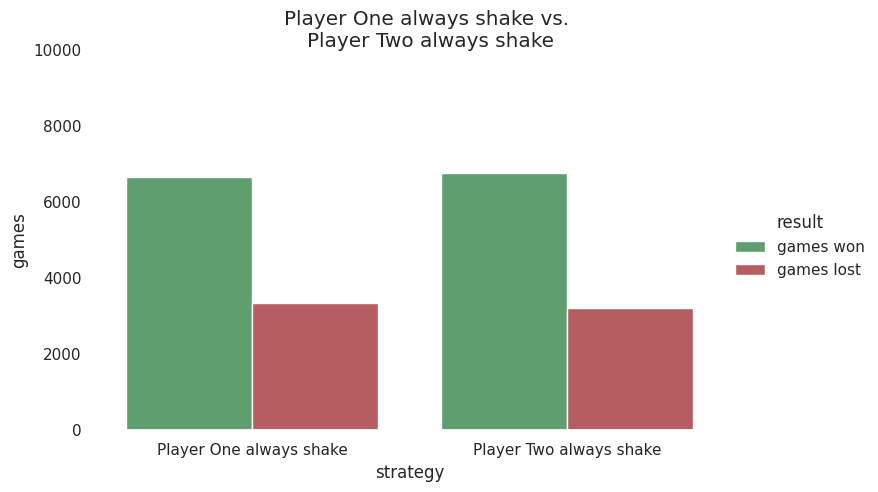

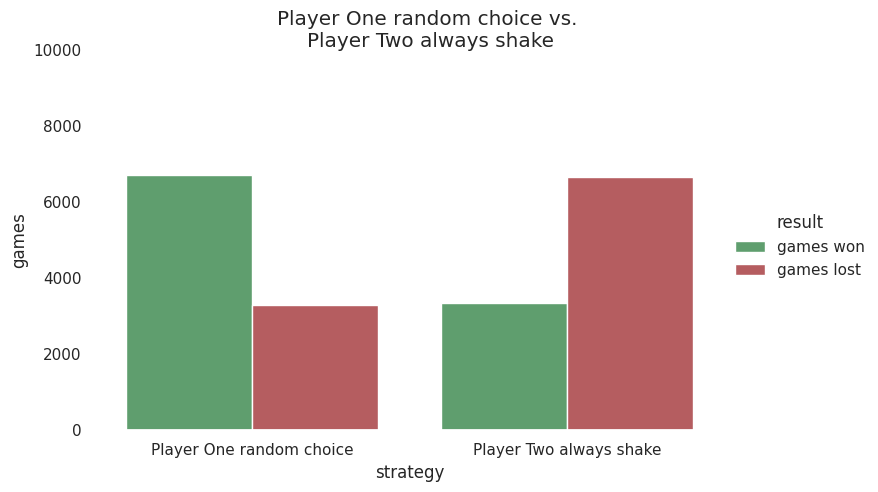

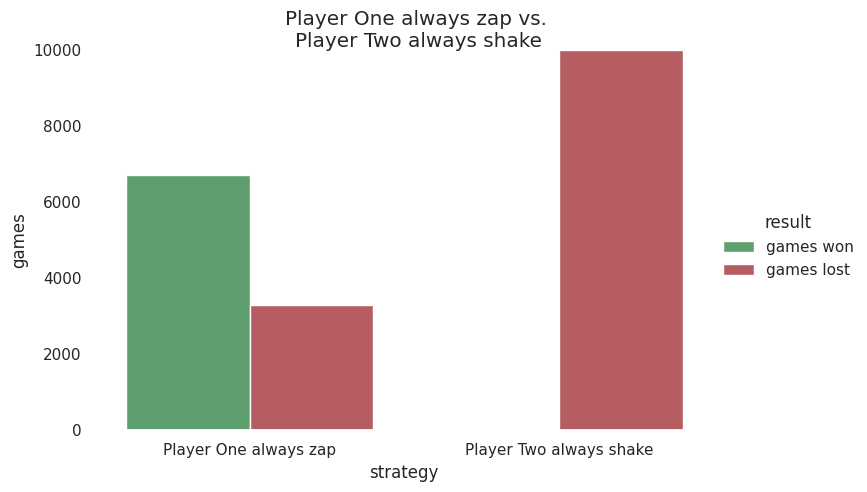

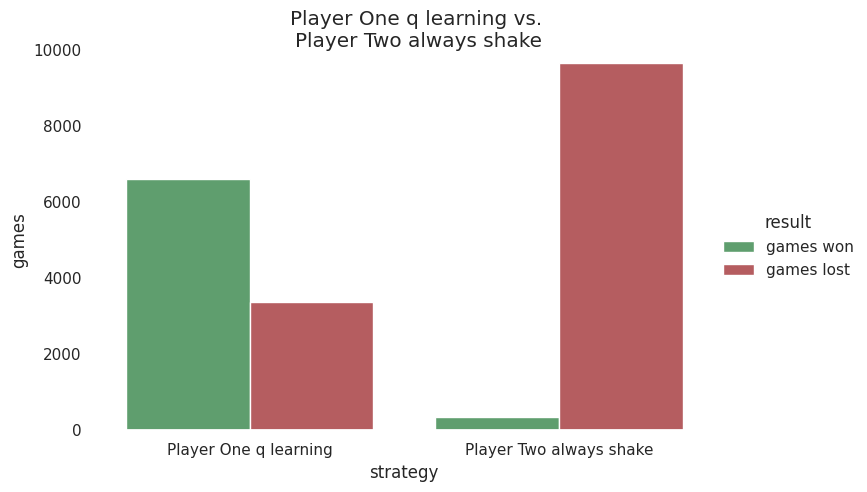

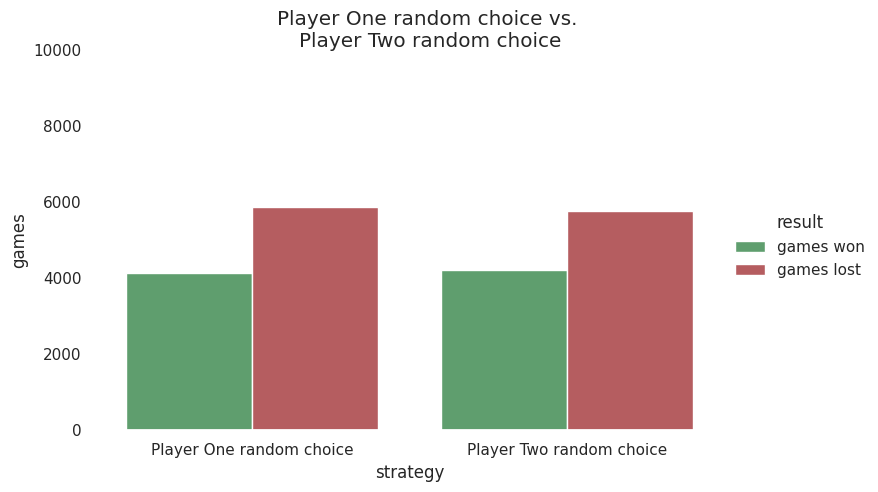

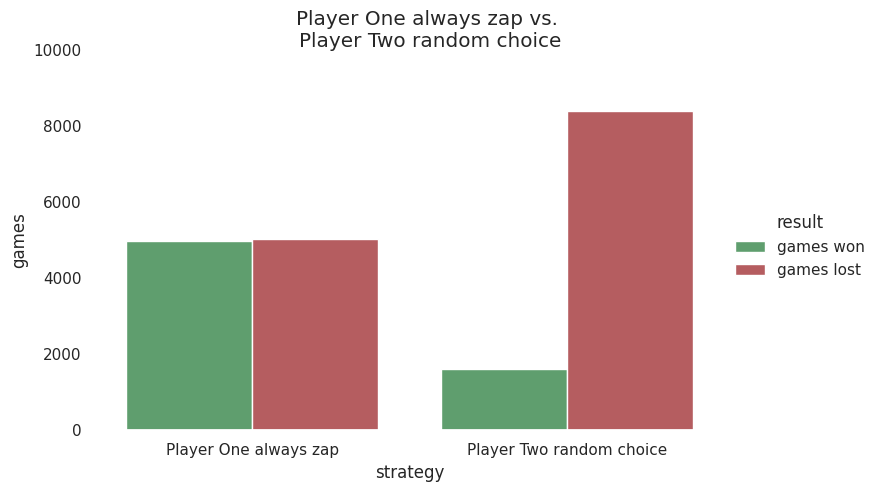

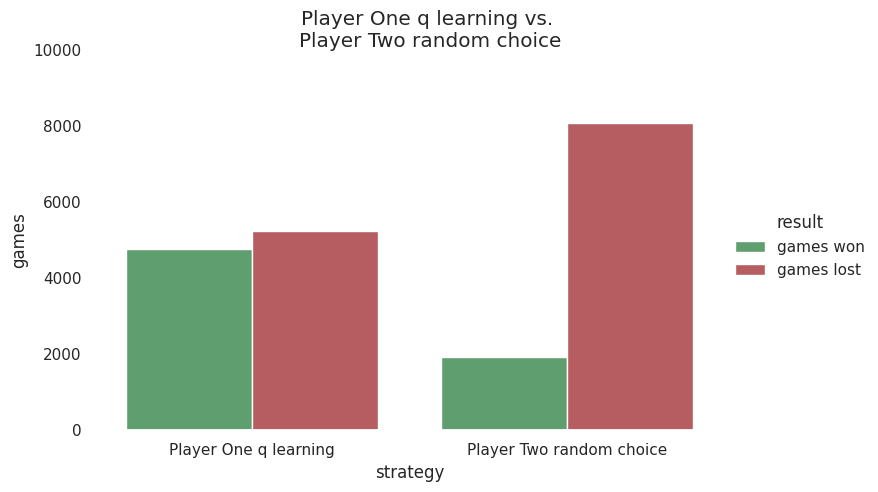

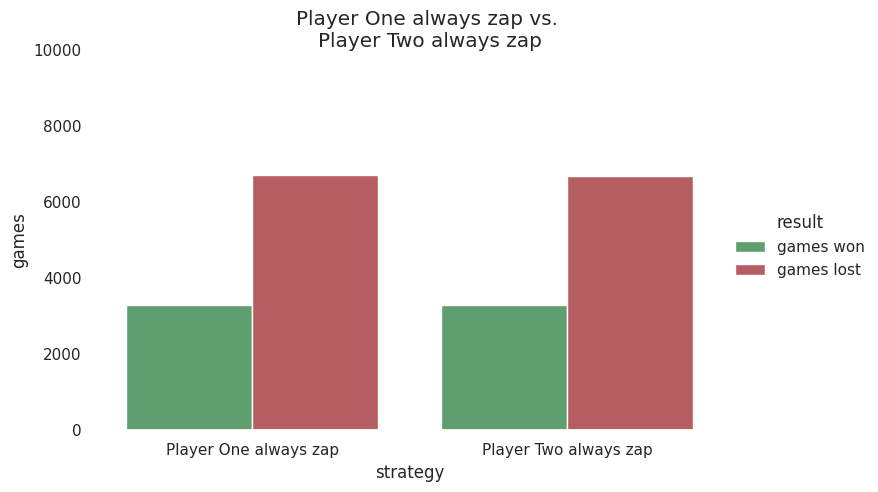

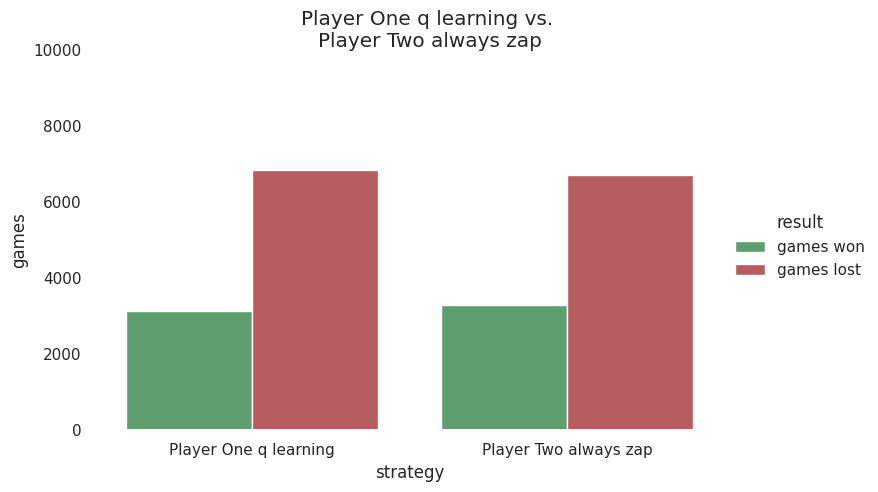

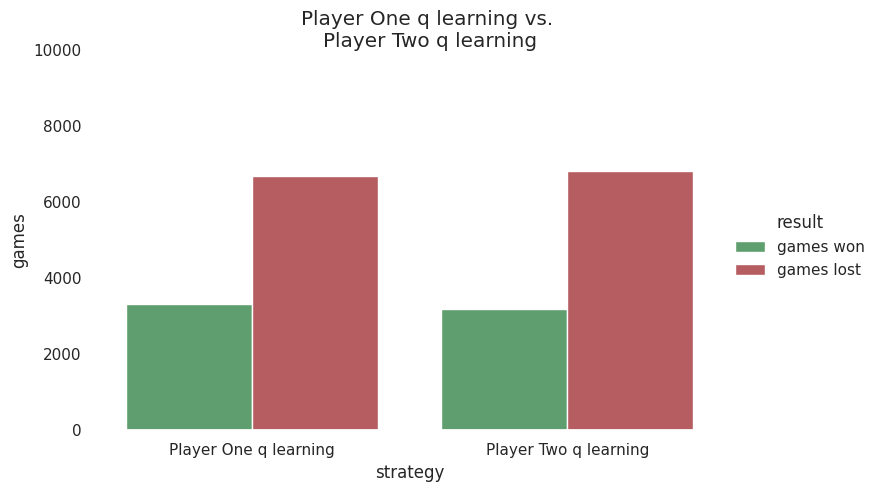

In [186]:
list(apply_fn_to_all_strategies(make_images_v2, basic_strats, 10000, "images"))

[None]

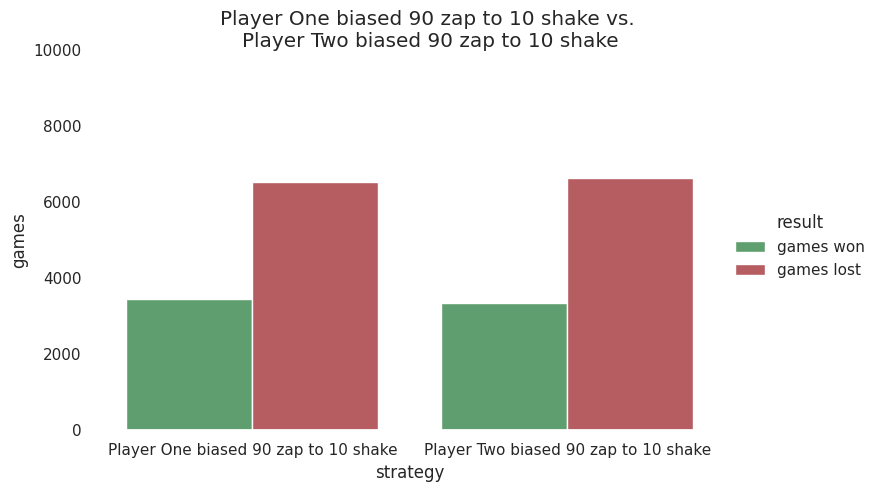

In [187]:
list(apply_fn_to_all_strategies(make_images_v2, [biased_90_zap_to_10_shake], 10000, "images"))

In [188]:
def get_trial(player_one, player_two, n):
    players = [player_one, player_two]
    deck = [Card.Human, Card.Robot, Card.Human]
    trial = Trial(players, deck[:], 100, n)
    return trial


[None, None, None, None, None, None, None, None, None, None]

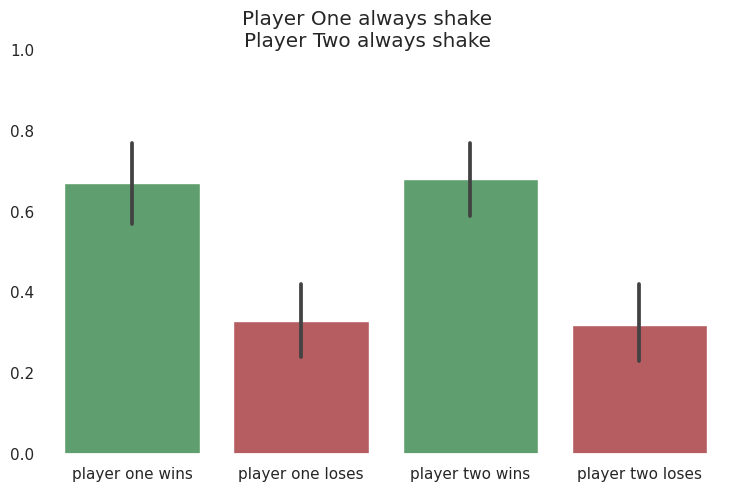

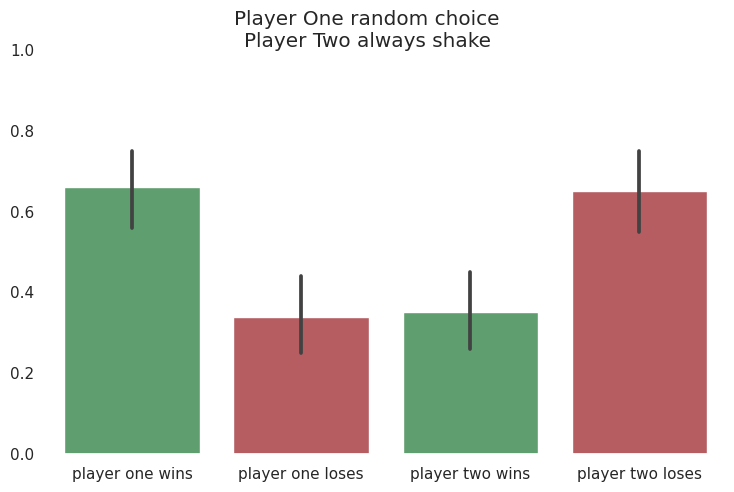

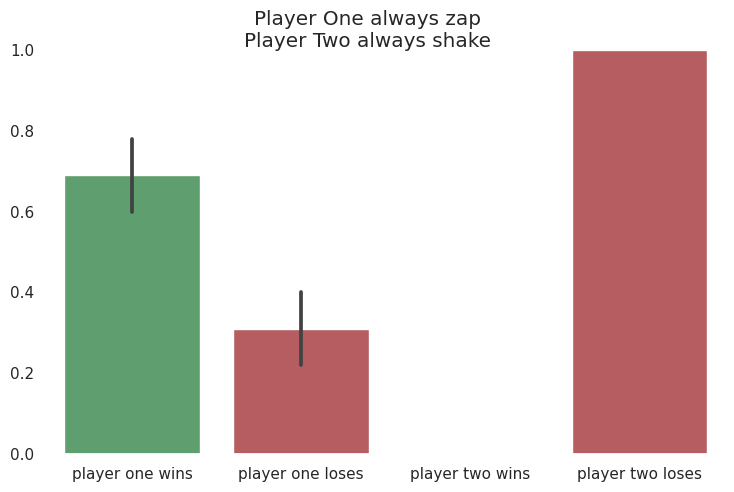

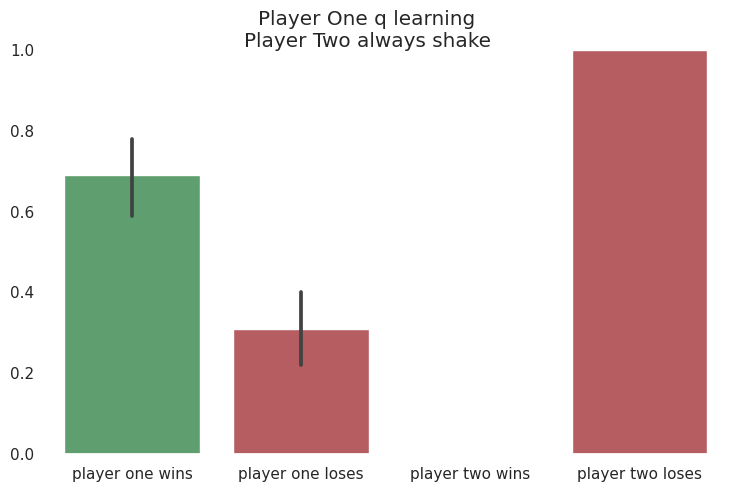

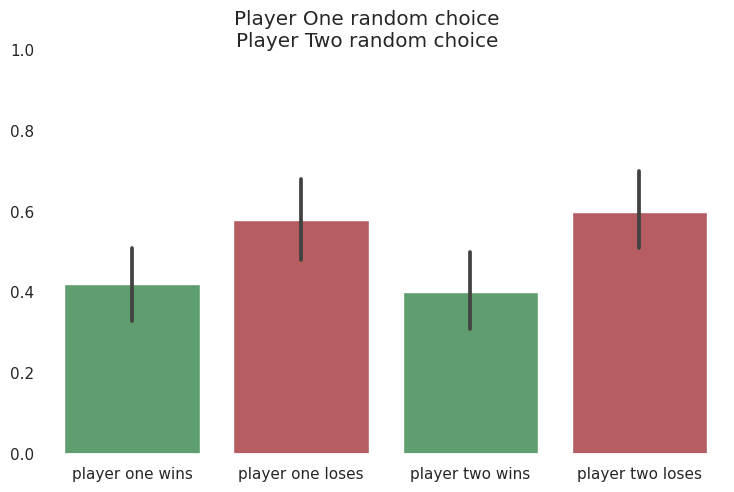

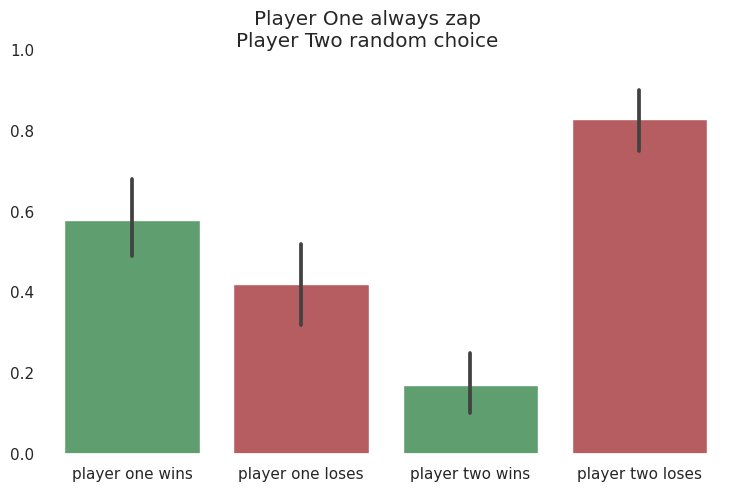

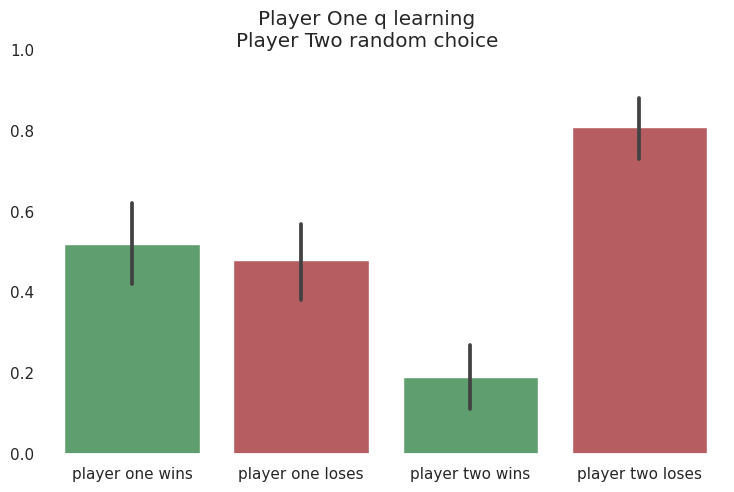

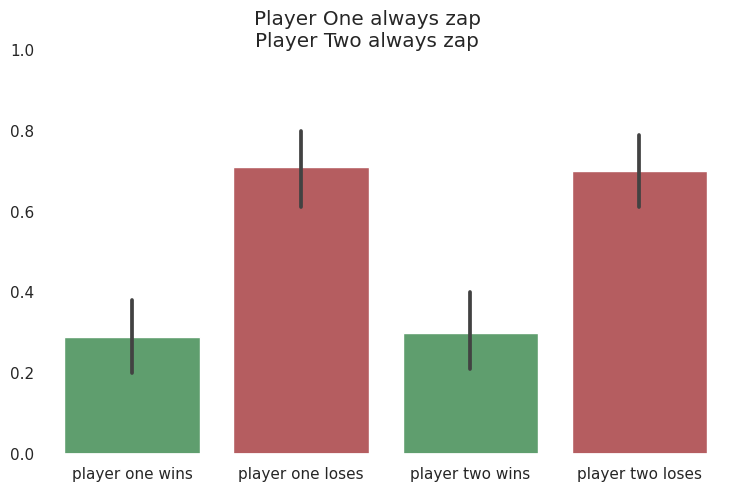

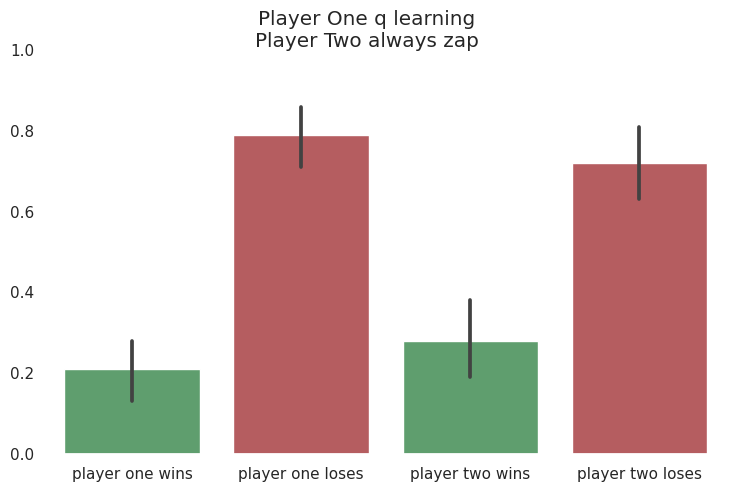

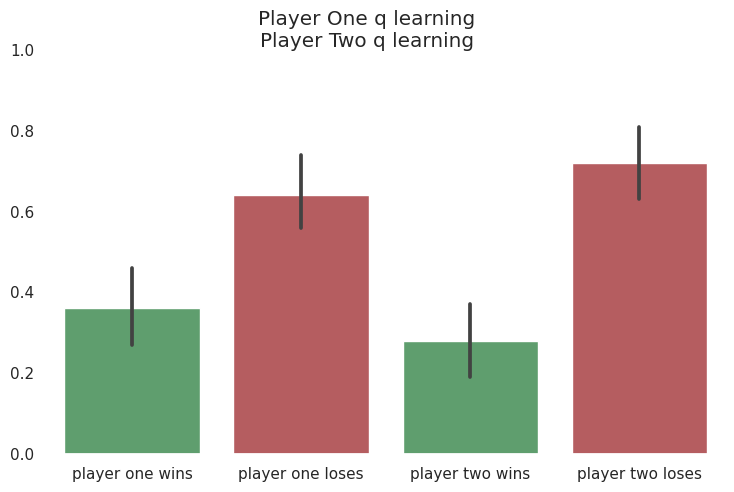

In [189]:
list(apply_fn_to_all_strategies(make_images, basic_strats, 100, "images"))

In [190]:
from collections import defaultdict
def strategy_win_loss_table(trials):
    acc = defaultdict(bool)
    for trial in trials:
        player_one = trial.players[0]
        player_two = trial.players[1]
        player_one_strat_text = player_one.strategy.__name__.replace("_", " ")
        player_one_wins = sum(trial.d["player one wins"])
        player_one_losses = sum(trial.d["player one loses"])
        player_two_strat_text = player_two.strategy.__name__.replace("_", " ")
        player_two_wins = sum(trial.d["player two wins"])
        player_two_losses = sum(trial.d["player two loses"])
        if acc[player_one_strat_text]:
            acc[player_one_strat_text]["wins"] += player_one_wins
            acc[player_one_strat_text]["losses"] +=  player_one_losses
        else:
            acc[player_one_strat_text] = {
                "wins": player_one_wins,
                "losses": player_one_losses
            }
        if acc[player_two_strat_text]:
            acc[player_two_strat_text]["wins"] += player_two_wins
            acc[player_two_strat_text]["losses"] += player_two_losses
        else:
            acc[player_two_strat_text] = {
                "wins": player_two_wins,
                "losses": player_two_losses
            }
    return acc   

In [191]:
def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text  # or whatever

In [192]:
def swlt_to_df(swlt):
    df_dict = {"games":[], "result":[], "strategy":[]}
    for k, v in swlt.items():
        df_dict["games"].append(v["wins"])
        df_dict["result"].append("win")
        df_dict["strategy"].append(k)
        df_dict["games"].append(v["losses"])
        df_dict["result"].append("lose")
        df_dict["strategy"].append(k)
    return pd.DataFrame.from_dict(df_dict)


In [193]:
import matplotlib.pyplot as plt
import os
# %matplotlib inline

# this takes a ton of memory
def make_bar_chart_biased(df, dir_prefix, title, order, aspect, n):

    trial_sns_plot = sns.catplot(
        # aspect=1.5,
        kind='bar', 
        data=df,
        x="strategy", y="games", hue="result", order=order,
        height=8.27, aspect=aspect

    )
    # trial_sns_plot.set_xticklabels(rotation=30, ha="right")
    # trial_sns_plot.fig.subplots_adjust(top=0.9)

    trial_sns_plot.fig.suptitle(title)
    
    # ax2 = trial_sns_plot.axes[0]
    trial_sns_plot.refline(y=n,color="red", linestyle="--", label="50% of games")
    trial_sns_plot.set(ylim=(0, n*2))
    image_path = title.replace(" ", "-").replace("\n","-")+".png"
    if dir_prefix:
        if not os.path.exists(dir_prefix):
            os.makedirs(dir_prefix)
        image_path = os.path.join(dir_prefix, image_path)
        
    trial_sns_plot.fig.savefig(image_path)

In [194]:
import matplotlib.pyplot as plt
import os
# %matplotlib inline

# this takes a ton of memory
def make_bar_chart(df, dir_prefix, title, order, aspect, n):

    trial_sns_plot = sns.catplot(
        # aspect=1.5,
        kind='bar', 
        data=df,
        x="strategy", y="games", hue="result", order=order,
        height=8.27, aspect=aspect

    )
    trial_sns_plot.set_xticklabels(rotation=30, ha="right")
    # trial_sns_plot.fig.subplots_adjust(top=0.9)

    trial_sns_plot.fig.suptitle(title)
    
    # ax2 = trial_sns_plot.axes[0]
    trial_sns_plot.refline(y=n,color="red", linestyle="--", label="50% of games")
    trial_sns_plot.set(ylim=(0, n*2))
    image_path = title.replace(" ", "-").replace("\n","-")+".png"
    if dir_prefix:
        if not os.path.exists(dir_prefix):
            os.makedirs(dir_prefix)
        image_path = os.path.join(dir_prefix, image_path)
        
    trial_sns_plot.fig.savefig(image_path)

In [195]:
n = 1000
basic_trials = apply_fn_to_all_strategies(get_trial, basic_strats, n)
basic_table = strategy_win_loss_table(basic_trials)
basic_bar_df = swlt_to_df(basic_table)

In [196]:
basic_bar_df

,games,result,strategy
0,1718,win,always shake
1,3282,lose,always shake
2,1803,win,random choice
3,3197,lose,random choice
4,2196,win,always zap
5,2804,lose,always zap
6,2050,win,q learning
7,2950,lose,q learning


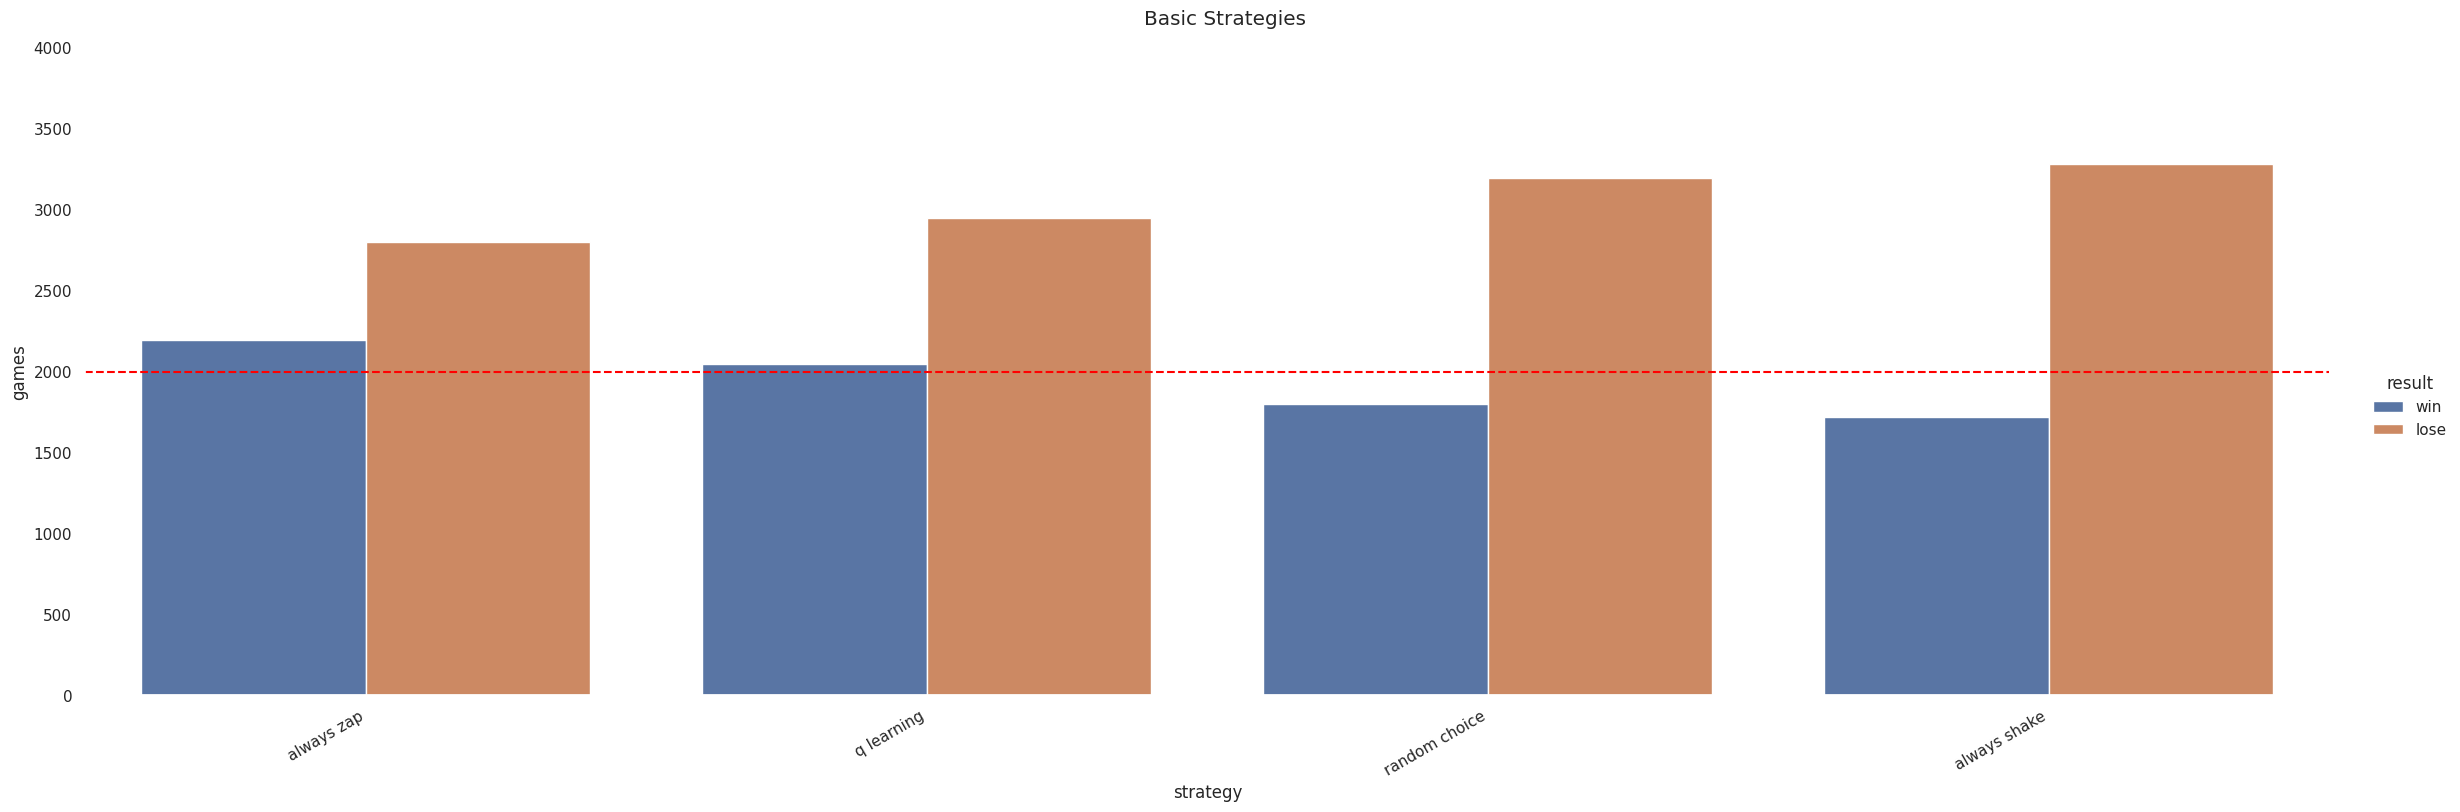

In [197]:
make_bar_chart(basic_bar_df,
               "", "Basic Strategies", 
               reversed(sorted(basic_table, key=lambda k: basic_table[k]["wins"])),
               23.8/8.27, n*len(basic_strats)//2)

In [198]:
n = 1000
trials = apply_fn_to_all_strategies(get_trial, all_strategies, n)
table = strategy_win_loss_table(trials)
all_strat_bar_df = swlt_to_df(table)

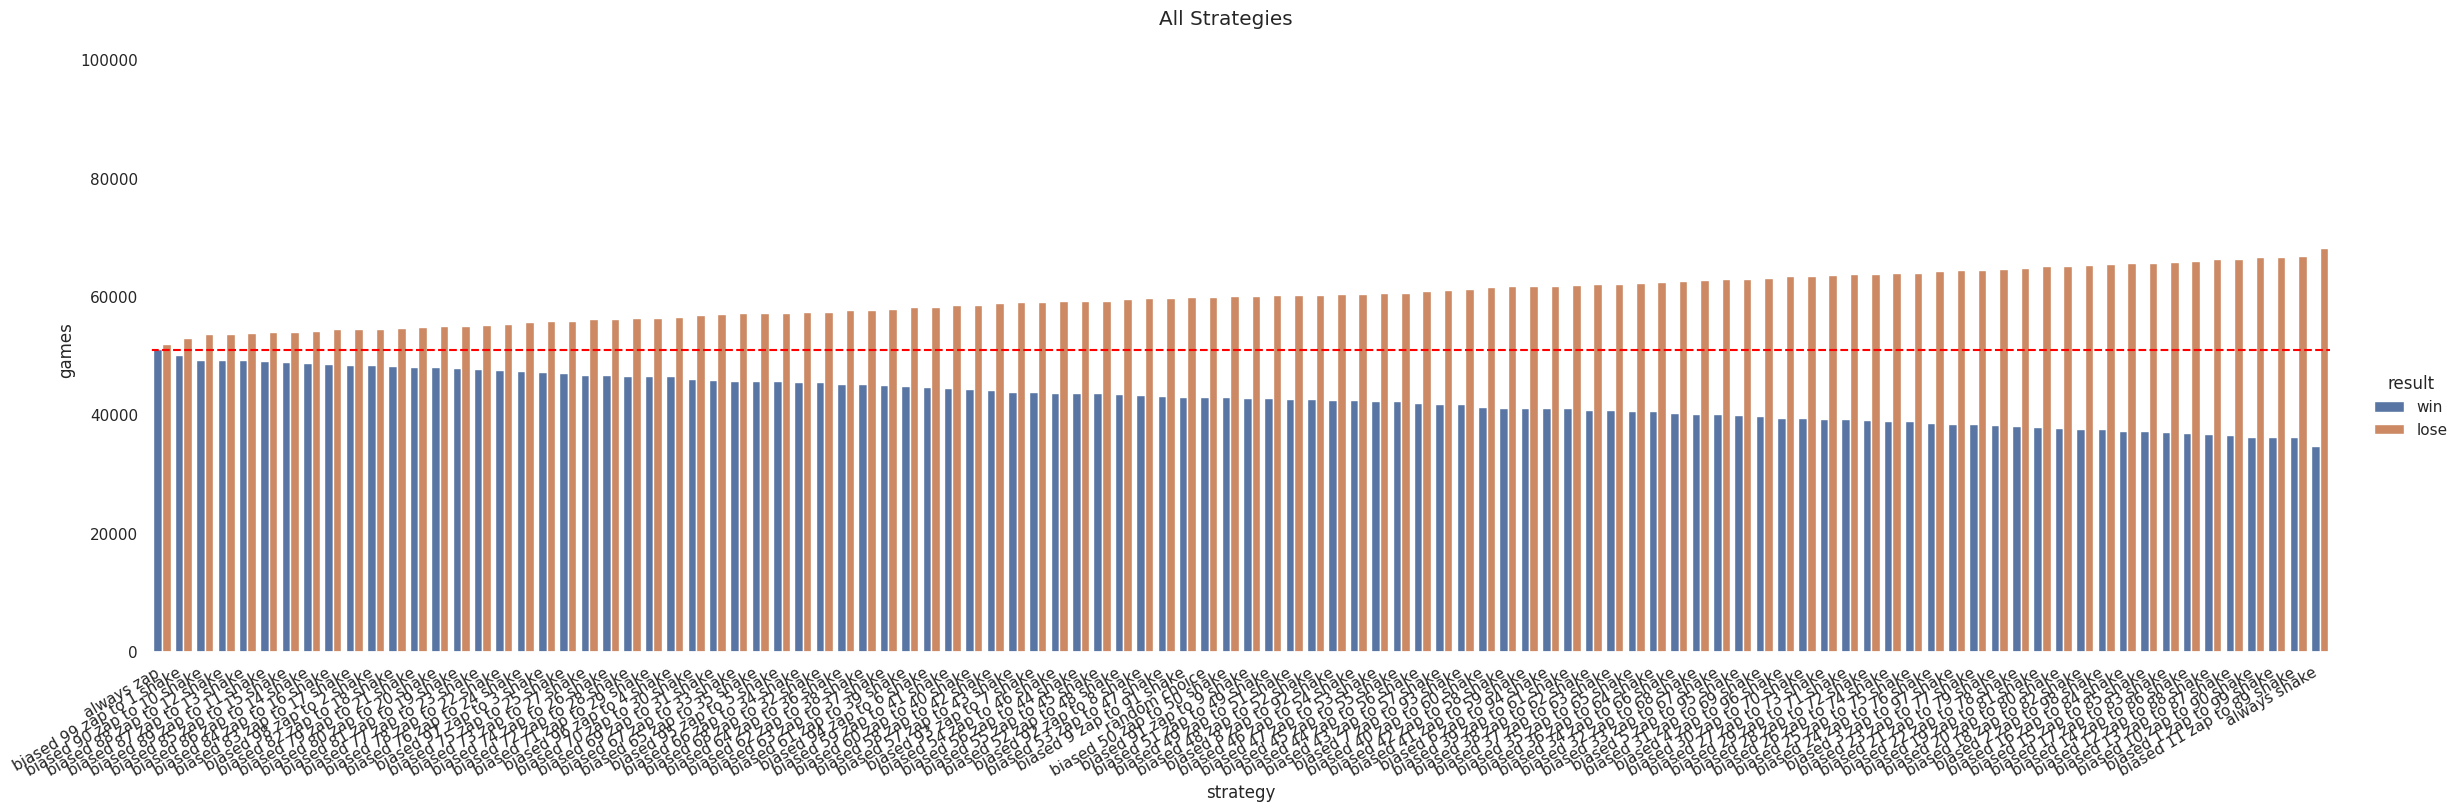

In [199]:
make_bar_chart(all_strat_bar_df,
               "", "All Strategies", 
               reversed(sorted(table, key=lambda k: table[k]["wins"])),
               23.8/8.27, n*len(all_strategies)//2)

In [200]:
n = 1000
biased_trials = apply_fn_to_all_strategies(get_trial, zap_biased_strats, n)
biased_table = strategy_win_loss_table(biased_trials)
zap_biased_bar_df = swlt_to_df(biased_table)

NameError: name 'zap_biased_strats' is not defined

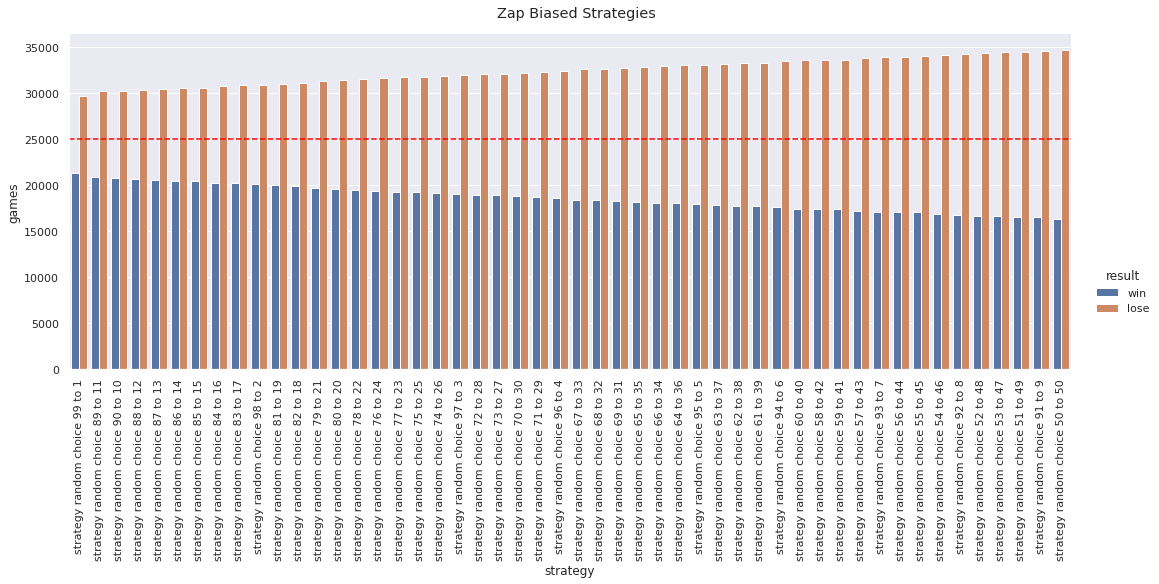

In [ ]:
make_bar_chart(zap_biased_bar_df, "", "Zap Biased Strategies", 
               reversed(sorted(biased_table, key=lambda k: biased_table[k]["wins"]))
               , 15.3/8.27,  n*len(zap_biased_strats)//2)

In [ ]:
n = 1000
reduced_sample_trials = apply_fn_to_all_strategies(get_trial, reduced_sample_strategies, n)
reduced_sample_table = strategy_win_loss_table(reduced_sample_trials)
reduced_sample_df = swlt_to_df(reduced_sample_table)


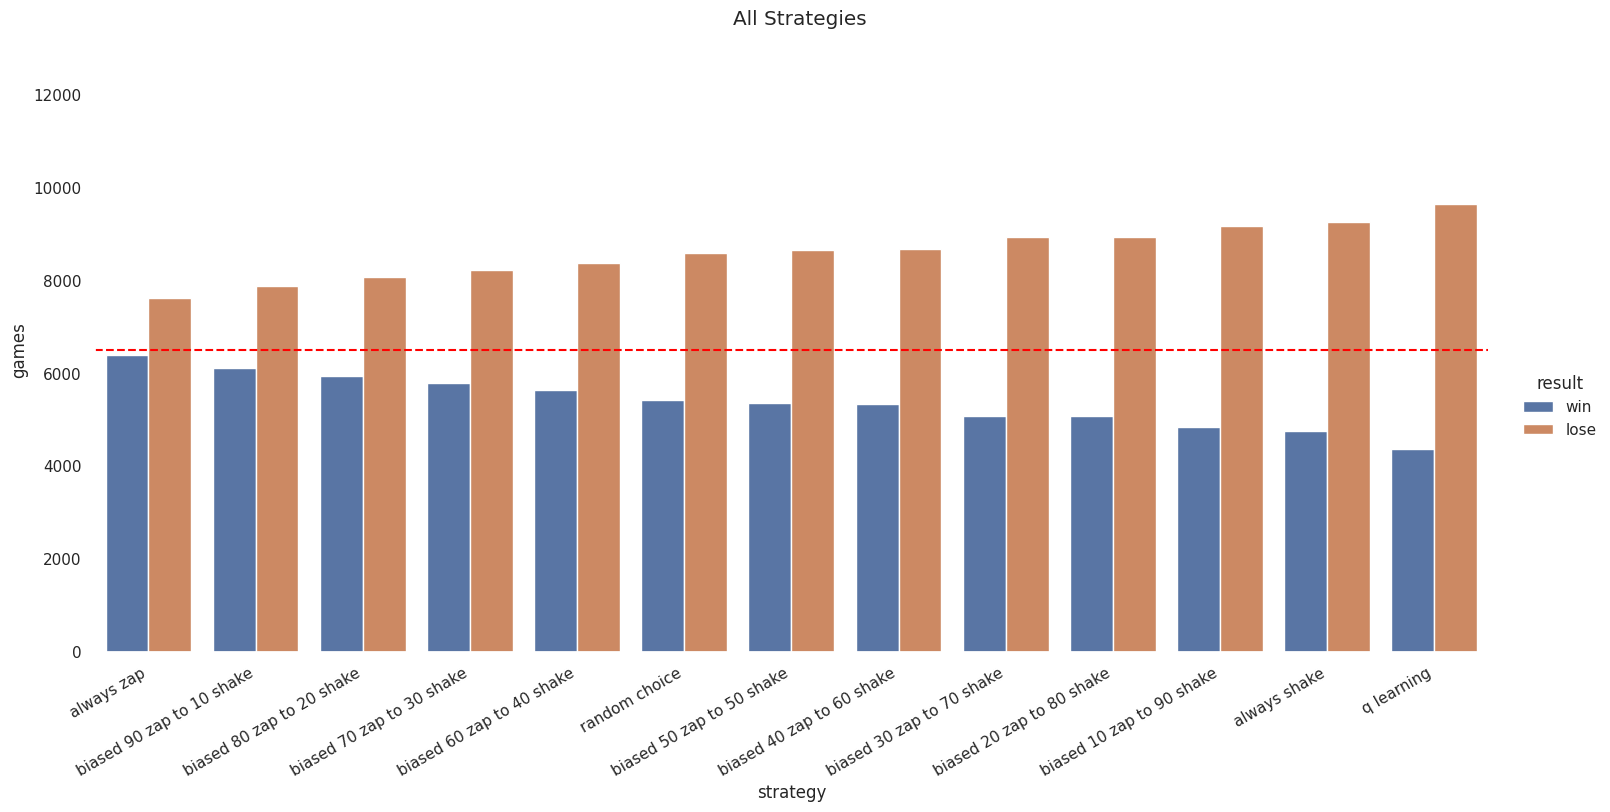

In [ ]:
make_bar_chart(reduced_sample_df, "", "All Strategies", 
               reversed(sorted(reduced_sample_table, key=lambda k: reduced_sample_table[k]["wins"]))
               , 15.3/8.27,  n*len(reduced_sample_table)//2)


In [ ]:
n = 1000
zb_reduced_sample_trials = apply_fn_to_all_strategies(get_trial, zap_biased_strats_smaller_sample, n)
zb_reduced_sample_table = strategy_win_loss_table(zb_reduced_sample_trials)
zb_reduced_sample_df = swlt_to_df(zb_reduced_sample_table)


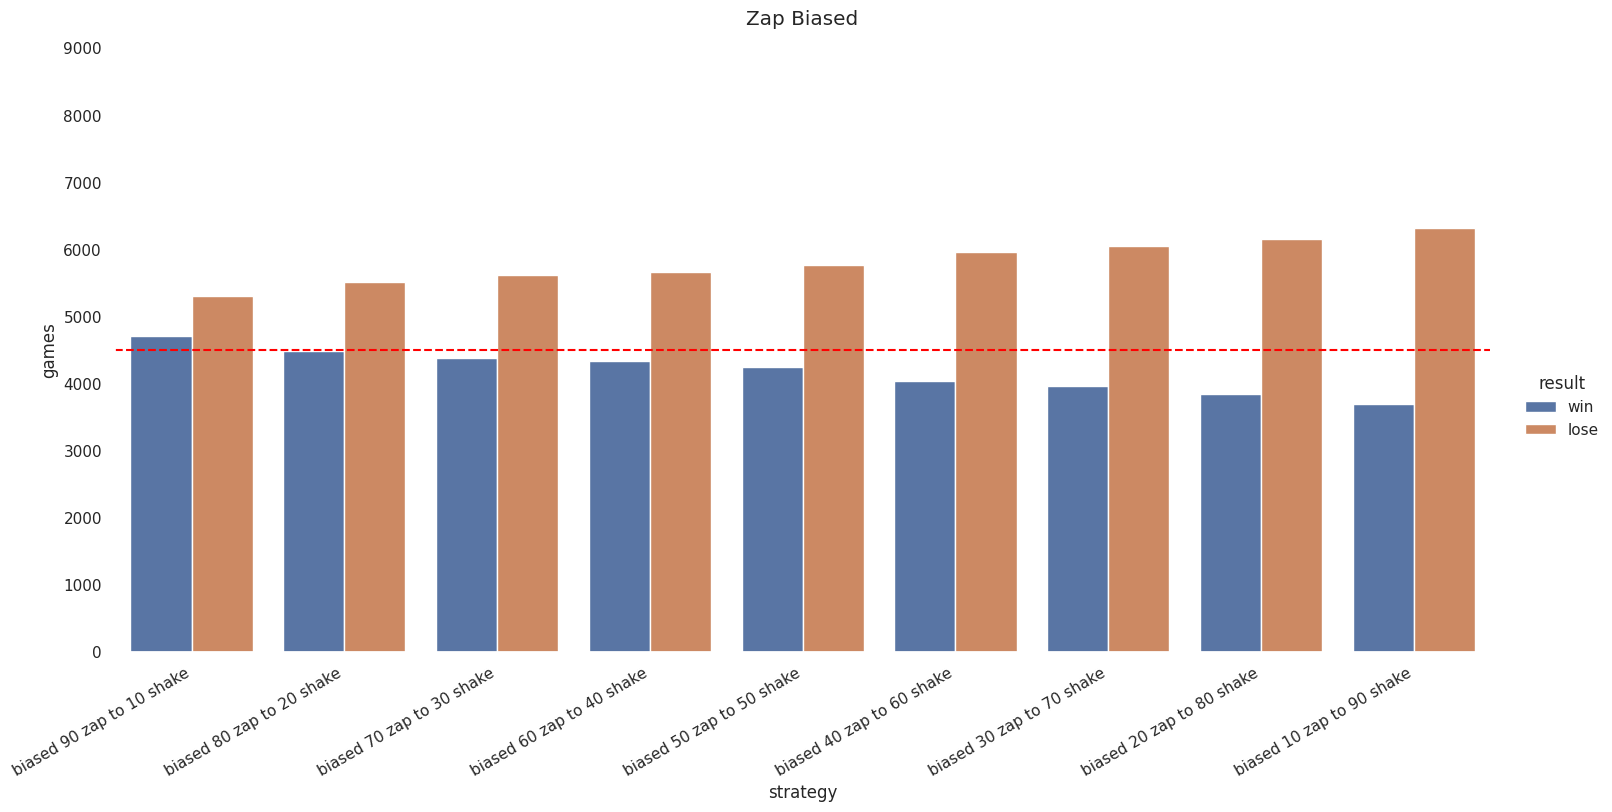

In [ ]:
make_bar_chart(zb_reduced_sample_df, "", "Zap Biased", 
               reversed(sorted(zb_reduced_sample_table, key=lambda k: zb_reduced_sample_table[k]["wins"]))
               , 15.3/8.27,  n*len(zb_reduced_sample_table)//2)
